Se empleará la biblioteca de Keras (biblioteca de Deep-learning para Python). Dicha biblioteca provee los envoltorios (wrappers) requeridos para la implementación, entrenamiento, validación y uso en producción de modelos de redes neuronales, en general, y Aprendizaje Profundo (Deep Learning) en particular, desarrollados sobre las rutinas de nivel más bajo de la biblioteca Tensorflow de Google (actualmente, se encuentran integrados).

# **Ejemplo básico: red feedforward para el problema del XOR**

En este ejemplo, para mostrar los elementos del uso de Keras para crear y entrenar redes neuronales, se presenta el caso estudiado en las sesiones del curso: un perceptrón lineal por si solo no basta si se quieren usar redes neuronales para implementar un clasificador capaz de implementar una función lógica XOR (problema del XOR, figura de la derecha).


Por ello, es necesario usar dos unidades que subdividan el espacio de características en tres regiones y luego una unidad de salida que integre las dos clasificaciones previas, con una arquitectura como la de la figura de la izquiera.

Al margen: si se cuenta con una tarjeta gráfica NVidia, se puede comprobar que se está usando dicha tarjeta con Keras y Tensorflow de la siguiente manera.

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

**Solución:**

Para implementar la red Feedfoward se usa el modelo "Sequential" de Keras, en el cual las capas de una red tienen exactamente un vector de entrada y un vector de salida.

Se usa la clase Dense que permite implementar capas completamente conectadas.

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense

In [ ]:
# the four different states of the XOR gate
training_set = np.array([[0,0],[0,1],[1,0],[1,1]], "float32")

# the four expected results in the same order
labels = np.array([[0],[1],[1],[0]], "float32")

In [ ]:
#recordar, diferencia paramatro e hiperparamatro
#parametro se modifican con el entrenamiento
#hiperparametro no se modifica durante el entrenamiento
#los parametros en la red neuronal, son los pesos aosicados a las conexiones en la red

### Función de activación o no activación de una neurona, a través de sigmoide con 0 o 1

- Se crea el modelo secuencial y se agregan las capas oculta y de salida de la red, usando las funciones de activación softmax

- poner más unidades en la capa oculta puede acelerar la convergencia (p.ej. 5)
- Una vez se ha definido la arquitectura, se usa la funcíon compile del modelo  para establecer la función de pérdida (loss, asociada al impacto del error en el desempeño de la red), el método de optimización (adam en este caso) y la métrica de precisión para el entrenamiento (_binaryaccuracy, dada la aplicación del modelo)
- Por último, se usa la función fit para entrenar el modelo, en este caso, usando 800 épocas (iteraciones sobre el dataset).
- El parámetro verbose permite controlar el detalle de la salida del método. Se puede poner a 0 para evitar una salida profusa.

In [ ]:
xor_nn = Sequential()
#capa densa de 4 y la entrada se hara a traveesde un vector de dimension 2
xor_nn.add(Dense(6, input_dim=2, activation='softmax'))
xor_nn.add(Dense(1, activation='sigmoid'))

xor_nn.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['binary_accuracy'])

xor_nn.fit(training_set, labels, epochs=800, verbose=0)

In [ ]:
print(xor_nn.predict(training_set).round())

[[0.]
 [1.]
 [1.]
 [0.]]


# **Ejemplo red neuronal**

En este ejemplo, se usará una red neuronal convolucional como la del esquema para entrenar un modelo que permita clasificar el conocido dataset "MNIST" (caracteres escritos a mano entrenados con una base de datos del servicio postal de Estados Unidos). Este datset está constituido por regiones de interés extraídas de imágenes (ROIs) que contienen dígitos escritos a mano por múltiples usuarios, etiquetados con el valor numérico asociado a cada ROI.

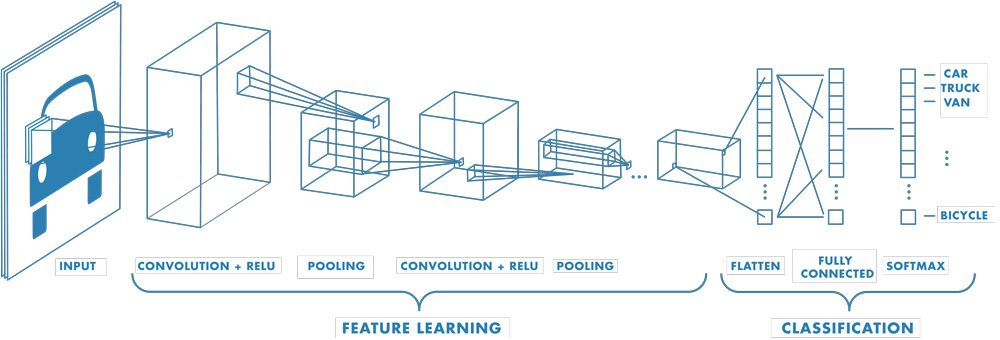

Las redes neuronales convolucionales están dentro de los modelos más usados para la clasificación de información visual

Se importa el dataset de MNIST desde la red usando keras y se asigna a los conjuntos de entrenamiento y prueba (ya están preestablecidos). Se usará una arquitectura secuencial con capas densas, convolucionales, de Pooling (submuestreo) y de regularización (Dropout). Este último evita el sobreajuste (overfitting) en el caso de las redes neuronales, favoreciendo la generalización:

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import cross_validate, KFold

import numpy as np

from keras.models import Sequential

#CON DROPOUT SE ELIMINAN NEURONAS INNECESARIOS
#DROPCONECT ELEIMINA CONEXIONES INNECESARIAS
#FLATTEN PERMITE CONVERTIR MAATRIZ EN VECTOR
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Como se verá más aldeante, se usará un envoltorio (wrapper) de Keras para sklearn, de modo que se pueda ejecutar una validación cruzada. Se puede observar el contenido del dataset usando la función imshow de matplotlib para una ROI con un índice arbitrario dado (hasta 60,000)

1


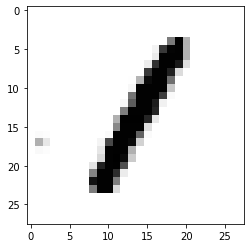

In [ ]:
dataset_idx = 11205 
print(y_train[dataset_idx]) # The label is 8
plt.imshow(x_train[dataset_idx], cmap='Greys')

In [ ]:
x_train.shape[0], 28, 28, 1

(60000, 28, 28, 1)

- Para poder usar este dataset en Keras, es necesario ajustar la representación de los datos a 4 dimensiones (la primera dimensión es el número de imágenes -ROIs-, la última es la profundidad de color de las ROIs, 1 para escala de grises)

- Así pues, las entradas tienen una única ROI. Todas las ROI se normalizarán a 28x28 (tamaño de la capa de entrada).

- Los valores de intensidad se normalizarán al intervalo [0,1]. Por tal razón, todos los píxeles se dividen por 255.

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
#28 FILAS 8 COLUMNAS SOLO 1 CANAL
#PARA REPRESENTAR SE PUEDE RGB, 3 CANALES
input_shape = (28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#SE NORMALIZAN PARA TENER VALORES ENTRE 0 Y 1

x_train /= 255
x_test /= 255


print('Tamaño del dataset de entrenamiento:', x_train.shape)
print('Número de ROIs en x_train', x_train.shape[0])
print('Número de ROIs en x_test', x_test.shape[0])

Tamaño del dataset de entrenamiento: (60000, 28, 28, 1)
Número de ROIs en x_train 60000
Número de ROIs en x_test 10000


# **Construcción del modelo de red neuronal convolucional**

En esta actualización, se usará una función constructora para crear el modelo usando un envoltorio (wrapper) de Keras para skLearn. Por esta razón, se creará la red con su arquitectura mediante una funcíon constructora.

Se usará solo una capa convolucional y una de Pooling (la versión MaxPooling usa el valor máximo para aplicar el submuestreo de regiones).

El tamaño de la matriz de convolución es de 
3
×
3
, el tamaño del filtro de submuestreo es 
2
×
2
. La capa de salida usa una función de activación softmax.

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
    #tomar valor maximo
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #aplanar a un vector unidemensional
    model.add(Flatten()) 

    #capa densa de activacion
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(10,activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

**Evaluación por Validación Cruzada**

El modelo así construido se puede evaluar usando una estrategia de Validación Cruzada (Cross Validation) sobre el dataset de entrenamiento. Para poder usar SKlearn sobre un modelo construido con Keeras se usa el wrapper KerasClassifier, que recibe como parámetro el modelo secuencial generado por la función constructora, el número de épocas y si genera salida por consola (además de otros parámetros por defecto). Usualmente, el número de particiones es de 5 o 10 (5-Fold o 10-Fold Cross Validation). También suelen usarse más épocas (100, 250) en los procesos de exploración de parámetros.

In [ ]:
neural_network = KerasClassifier(build_fn=create_model, verbose=1, epochs=5)
kfold = KFold(n_splits=3, random_state=np.random.seed(7))

results = cross_validate(neural_network,x_train, y_train, cv=3, scoring = ['accuracy'], return_train_score=True)

Epoch 1/5
1250/1250 [==============================] - 20s 16ms/step - loss: 2.3045 - accuracy: 0.1043
Epoch 2/5
1250/1250 [==============================] - 19s 16ms/step - loss: 2.3019 - accuracy: 0.1102
Epoch 3/5
1250/1250 [==============================] - 19s 16ms/step - loss: 2.3014 - accuracy: 0.1116
Epoch 4/5
1250/1250 [==============================] - 19s 15ms/step - loss: 2.3016 - accuracy: 0.1087
Epoch 5/5
 19/625 [..............................] - ETA: 3s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1250/1250 [==============================] - 7s 6ms/step
Epoch 1/5
1250/1250 [==============================] - 20s 15ms/step - loss: 2.3043 - accuracy: 0.1058
Epoch 2/5
1250/1250 [==============================] - 19s 16ms/step - loss: 2.3019 - accuracy: 0.1127
Epoch 3/5
1250/1250 [==============================] - 19s 15ms/step - loss: 2.3012 - accuracy: 0.1130
Epoch 4/5
1250/1250 [==============================] - 19s 15ms/step - loss: 2.3011 - accuracy: 0.1126
Epoch 5/5
1250/1250 [==============================] - 7s 5ms/step
Epoch 1/5
1250/1250 [==============================] - 19s 15ms/step - loss: 2.3038 - accuracy: 0.1071
Epoch 2/5
1250/1250 [==============================] - 19s 15ms/step - loss: 2.3015 - accuracy: 0.1149
Epoch 3/5
1250/1250 [==============================] - 19s 15ms/step - loss: 2.3009 - accuracy: 0.1149
Epoch 4/5
1250/1250 [==============================] - 19s 15ms/step - loss: 2.3008 - accuracy: 0.1154
Epoch 5/5
1250/1250 [==============================]

# **Predicción (uso del modelo entrenado)**

En este ejemplo, para el uso en predicción (clasificación de casos no usados en el entrenamiento, p.ej. en una aplicación en producción), se entrenará el modelo de clasificación con 5 épocas (este parámetro se puede cambiar)

In [ ]:
neural_network.fit(x=x_train,y=y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 30s 16ms/step - loss: 2.3035 - accuracy: 0.1081
Epoch 2/5
1875/1875 [==============================] - 29s 16ms/step - loss: 2.3013 - accuracy: 0.1139
Epoch 3/5
1875/1875 [==============================] - 29s 15ms/step - loss: 2.3015 - accuracy: 0.1128
Epoch 4/5
1875/1875 [==============================] - 29s 16ms/step - loss: 2.3012 - accuracy: 0.1130
Epoch 5/5
1875/1875 [==============================] - 29s 16ms/step - loss: 2.3013 - accuracy: 0.1132


1/1 [==============================] - 0s 13ms/step
[1]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


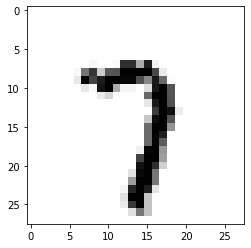

In [ ]:
image_index = 1321
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')

prediction = neural_network.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(prediction)

# **Redes recurrentes**

Modelo LSTM para pronóstico en series de tiempo
Las redes recurrentes son un modelo especialmente adecuado para abordar problemas relacionados con el análisis de series temporales (usualmente, problemas de regresión)

Ejemplo: predicción del número de pasajeros en una aerolínea a partir de datos históricos de pasajeros. En este ejemplo sencillo, solo usaremos un paso hacia atrás (retroalimentación de un único valor de salida previo) para pronosticar el valor siguiente (ventana temporal=1)

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
#error cuadratico medio sobre la prediccion varios pasos adelante
from sklearn.metrics import mean_squared_error

In [ ]:
# se inicia la semilla del módulo de números aleatorios de numpy
numpy.random.seed(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 1.2 KB


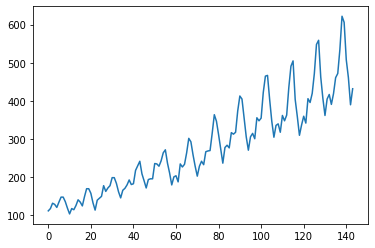

In [ ]:
# se carga el dataset
dataframe = pandas.read_csv('pasajeros.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32') #El tipo de dato es importante para el método de optimización

dataframe.head(5)
dataframe.info()

plt.plot(dataset)
plt.show()

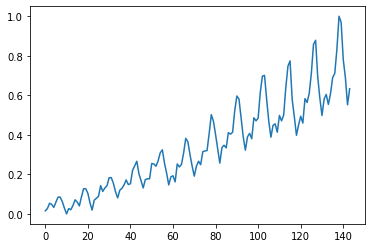

In [ ]:
# se normaliza el dataset a un intervalo 0 - 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
plt.plot(dataset)
plt.show()

In [ ]:
#Partición para entrenamiento y prueba: se usará el 70 % del dataset para entrenamiento y el 30 % para pruebas

train_size = int(len(dataset) * 0.70) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("Tamaño del dataset de entrenamiento: ",len(train),"- Tamaño del dataset de prueba: ", len(test))

Tamaño del dataset de entrenamiento:  100 - Tamaño del dataset de prueba:  44


Preparación de los datos:
El dataset deberá convertirse a una estructura de datos apropiada para su uso en los modelos de redes neuronales (recurrentes en este caso) implementados en la biblioteca Keras.

Como se usará solo 1 paso previo como retroalimentación del modelo recurrente, se crea una función que organiza los datos de entrada para que tengan esa salida previa como entrada, usando la variable lookback inicializada a 1.

In [ ]:
def create_dataset(dataset, lookback=1):
    dataX, dataY = [], [] # listas estándar de python
    for i in range(len(dataset)-lookback-1): # agregar uno a uno los elementos de las listas
        a = dataset[i:(i+lookback), 0]
        dataX.append(a)
        dataY.append(dataset[i + lookback, 0])
    return numpy.array(dataX), numpy.array(dataY) #convertir las listas en arrays de numpy para retornarlas

In [ ]:
lb = 1
trainX, trainY = create_dataset(train, lb)
testX, testY = create_dataset(test, lb)

# modificar la forma de los vectores de entrada para que sea del tipo: [muestras, paso de tiempo, caracteísticas]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Crear un modelo LTSM de una entrada, 4 unidades LSTM en una única capa oculta y una capa de salida de un único valor

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, lb)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
98/98 [==============================] - 1s 1ms/step - loss: 0.0542
Epoch 2/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0181
Epoch 3/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 4/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 5/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 6/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 7/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 8/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 9/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 10/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 11/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0072
Epoch 12/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 13/100
98/98 [=================

In [ ]:
#Obtener las predicciones que arroja el modelo entrenado:

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
#Error del pronóstico: Se calculan los errores RMSE (raíz del error medio cuadrático)

# invertir las predicciones para entrenamiento y prueba
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calcular el error del pronóstico 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.28 RMSE
Test Score: 49.73 RMSE


Graficar el resultado: se deben desplazar los valores pronosticados para tiempos posteriores a aquellos del dataset de entrenamiento

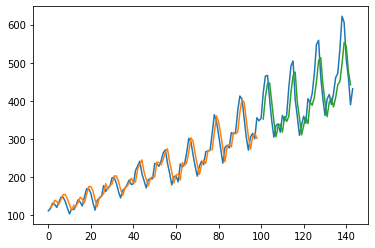

In [ ]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[lb:len(trainPredict)+lb, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(lb*2)+1:len(dataset)-1, :] = testPredict

# Ahora, se pueden graficar los valores de entrenamiento y los valores pronosticados vs. los valores reales observados
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()